# First simple web-map with Folium


**Date**: 22.03.2023

**Course**: Methods of Spatial Analysis. Advanced Level. // HSE, Moscow, spring 2023

## 1. Import libraries

In [1]:
# Restart the kernel
import IPython
IPython.Application.instance().kernel.do_shutdown(True)
print('Ядро перезапущено, можно продолжать работать!')

Ядро перезапущено, можно продолжать работать!


In [3]:
## For working with dataframes

import pandas as pd
import geopandas as gpd
import folium

from shapely import geometry


## 2.Read data from a geojson file

In [4]:
data = gpd.read_file('./arkh_points.geojson')
data.head()

,fid,Объект,Номер в реестре,Полный адрес,Регион,Категория историко-культурного значения,Тип объекта культурного наследия,Вид объекта,описание предмета охраны,текстовое описание границ,Особо ценный объект,идентификатор ансамбля,дата создания,lat,lon,maybe_okn,Function,geometry
0,1,Дом Спаде (дирекция строящейся атомной станции...,3.213100e+14,"Архангельская область, г. Архангельск, ул. Кар...",Архангельская область,Регионального значения,NA,Памятник,Предметом охраны культурного наследия являются...,NaN,нет,NA,конец XIX - начало XX вв.,64.54497,40.51434,NaN,административное здание,POINT (572610.351 7158610.939)
1,2,Особняк Плюснина (детский сад АЛТИ),3.213100e+14,"Архангельская область, г. Архангельск, проспек...",Архангельская область,Регионального значения,NA,Памятник,Предметом охраны являются: -градостроительны...,NaN,нет,NA,1909 г.,64.53402,40.53986,NaN,образование,POINT (573881.036 7157419.989)
2,3,Особняк Калинина (жилой дом),3.213100e+14,"Архангельская область, г. Архангельск, проспек...",Архангельская область,Регионального значения,NA,Памятник,Предметом охраны являются: - градостроительн...,NaN,нет,NA,1906 г.,64.53743,40.52888,NaN,жилой дом,POINT (573341.404 7157789.790)
3,4,Здание 2-й полицейской части (институт морфоло...,3.213100e+14,"Архангельская область, г. Архангельск, проспек...",Архангельская область,Регионального значения,NA,Памятник,Предметом охраны являются: - градостроительн...,NaN,нет,NA,начало XIX в.,64.55351,40.52657,NaN,административное здание,POINT (573186.097 7159576.788)
4,5,Духовная семинария (Архангельский педагогическ...,3.213100e+14,"Архангельская область, г. Архангельск, проспек...",Архангельская область,Регионального значения,NA,Памятник,Предметом охраны являются: - градостроительн...,NaN,нет,NA,1908-1910 гг.,64.53051,40.56494,NaN,религиозный объект,POINT (575079.978 7157079.547)


#### * clear data and save only valuable attributes
(here is an example how to drop  fields, you may need to delete more/less depends, you may choose another way to remove attributes )

In [5]:
data = data.drop(columns=['Тип объекта культурного наследия', 'текстовое описание границ' ])

## 2.Create Grid (fishnet)
* to plot concentration of cultural heritage (or any other point layer) with a choropleth map

#### 2.1. Check CRS of current data and decide do you need to reproject it or not?

* here is an example of reading the current crs and reprojecting geodataframe to another crs (you need to choose by yourself do you need it or not), but I'd rather reccommend to use UTM-zone, when you plot data with folium it is better to choose Web Mercator (EPSG:3857)

In [6]:
print(data.crs.name)

#if you need to reproject you can use .to_crs method
#data = data.to_crs("EPSG:4326")


WGS 84 / UTM zone 37N


#### 2.2. Get the extent of the data

In [7]:
total_bounds = data.total_bounds
minX, minY, maxX, maxY = total_bounds

#### 2.3. Select cell-size 

* what are the units?

In [10]:
square_size = 500

#### 2.4. Create fishnet

* you may choose another way to create using QGIS and read prepared data here

In [9]:
grid_cells = []
x, y = (minX, minY)
geom_array = []

while y <= maxY:
        while x <= maxX:
            geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            geom_array.append(geom)
            x += square_size
        x = minX
        y += square_size


fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:32637')
fishnet['id'] = fishnet.index

* save final grid to file if you need it 

In [12]:
#fishnet.to_file('grid.gpkg')

## 3. Count Points in Polygon

#### 3.1. Merge fishnet and your points data to count them in polygons

In [11]:
merged = gpd.sjoin(data, fishnet, how='left', op='within')
merged['n'] = 1
dissolve = merged.dissolve(by="index_right", aggfunc="count")
fishnet.loc[dissolve.index, 'n'] = dissolve.n.values


/Users/belka/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


#### 3.2. Plot the result

* we do it just to check the final result, no any other practical need

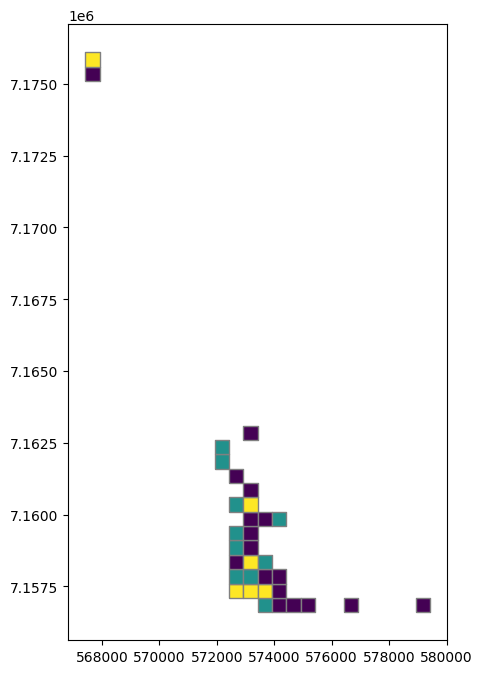

In [23]:
ax = fishnet.plot(column='n', figsize=(12, 8), cmap='viridis', scheme='natural_breaks', k=3, edgecolor="grey")


## 3. Create Web-map

#### 3.1 Map Settings
* carefully look at the function, try to understand what each variable stands for

In [36]:
data = data.to_crs('EPSG:4326')
m = folium.Map(location=[data.centroid.y.mean(), data.centroid.x.mean()], zoom_start=12,  tiles="cartodb positron", control_scale=True)


/var/folders/ry/9bb7wrz54vq_kn2ytlj6ynzm0000gn/T/ipykernel_97711/440777897.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[data.centroid.y.mean(), data.centroid.x.mean()], zoom_start=12,  tiles="cartodb positron", control_scale=True)
/var/folders/ry/9bb7wrz54vq_kn2ytlj6ynzm0000gn/T/ipykernel_97711/440777897.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[data.centroid.y.mean(), data.centroid.x.mean()], zoom_start=12,  tiles="cartodb positron", control_scale=True)


#### 3.2 Explore the map box. Do we need any changes?

In [35]:
m

#### 3.3 Create a Choropleth map based on a fishnet

In [37]:
folium.Choropleth(
    geo_data=fishnet,
    data=fishnet,
    columns=['id', 'n'],
    fill_color='RdBu',
    use_jenks=True,
).add_to(m)

In [38]:
m

In [ ]:
fishnet.head()

,geometry,n
0,"POLYGON ((567422.216 7156597.614, 567422.216 7...",NaN
1,"POLYGON ((568422.216 7156597.614, 568422.216 7...",NaN
2,"POLYGON ((569422.216 7156597.614, 569422.216 7...",NaN
3,"POLYGON ((570422.216 7156597.614, 570422.216 7...",NaN
4,"POLYGON ((571422.216 7156597.614, 571422.216 7...",NaN


In [29]:
folium.LayerControl().add_to(m)

In [30]:
m

In [66]:
folium.features.GeoJson(df_test.to_json()).add_to(m)

In [34]:
from folium.plugins import MousePosition
MousePosition().add_to(m)

In [35]:
m

In [36]:

from folium.plugins import MeasureControl
m.add_child(MeasureControl())

In [37]:
from folium.plugins import MarkerCluster

In [38]:
MarkerCluster(df_test).add_to(m)

ValueError: Expected two (lat, lon) values for location, instead got: [1, 'Дом Спаде (дирекция строящейся атомной станции теплоснабжения)', 321310008970005.0, 'Архангельская область, г. Архангельск, ул. Карла Маркса, д. 6', 'Архангельская область', 'Регионального значения', 'Памятник', 'Предметом охраны культурного наследия являются:   - градостроительные характеристики объекта культурного наследия, его местоположение и роль в композиционно-планировочной структуре квартала;   - объёмно-пространственная композиция объекта культурного наследия, включая его высотные отметки, габариты и конфигурацию здания;   - композиция и архитектурно-художественное оформление фасадов здания;   - характер отделки фасадов объекта культурного наследия;   - колористическое решение фасадов объекта культурного наследия;   - столярные заполнения дверных и оконных проемов на фасадах объекта культурного наследия.    ', 'нет', 'NA', 'конец  XIX - начало  XX вв.', 64.54497, 40.51434, nan, 'административное здание', <POINT (40.514 64.545)>].

In [39]:
from folium.plugins import Fullscreen

Fullscreen(
    position="topright",
    title="Expand me",
    title_cancel="Exit me",
    force_separate_button=True,
).add_to(m)

In [40]:
m

In [41]:
from folium.plugins import MiniMap



minimap = MiniMap()
m.add_child(minimap)

In [42]:
marker_cluster = MarkerCluster().add_to(m)